# PDE-FIND for identifying Navier-Stokes

Samuel Rudy, 2016

This notebook demonstrates PDE-FIND for the vorticity equation given a simulation of fluid flowing around a cylinder.
\begin{align*}
\omega_t &= \frac{1}{Re}\nabla^2 \omega - (V \cdot \nabla)\omega\\
V &= (v,u)\\
Re &= 100
\end{align*}
The x and y components of the velocity field are given as forcing terms to the PDE.  That is, they appear in $\Theta$, but are not differentiated.

In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import sys; sys.path.append('../')
from PDE_FIND import *
import scipy.io as sio
import itertools

Populating the interactive namespace from numpy and matplotlib


Load in the data.

In [ ]:
data = sio.loadmat('/Users/pongpisit/Desktop/research/DeepHPMs/Data/cylinder.mat')

U_star = data['U_star'] # N x 2 x T
P_star = data['w_star'] # N x T
t_star = data['t_star'] # T x 1
X_star = data['X_star'] # N x 2

N = X_star.shape[0]
T = t_star.shape[0]

UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

x = np.unique(X_star[:,0:1]).flatten()
y = np.unique(X_star[:,1:2]).flatten()
t = t_star.flatten()

usol = UU.reshape(len(x), len(y), len(t))
vsol = VV.reshape(len(x), len(y), len(t))
wsol = PP.reshape(len(x), len(y), len(t))

# Load data
steps = len(t)
n = len(x)
m = len(y)

U = usol
V = vsol
W = wsol

dt = t[1]-t[0]
dx = x[1]-x[0]
dy = y[1]-y[0]

n,m,steps = W.shape

Here we take the SVD of the data and reconstruct either with a reduced basis or everything.  It isn't necesarry but is interesting to show that we can still derive the correct PDE with the first 50 modes (maybe less). 

In [ ]:
# Original Code
# # Load data
# steps = 151
# n = 449
# m = 199
# U = np.load('../Datasets/course_timestep_cylinder/Cylinder_U.npy')
# V = np.load('../Datasets/course_timestep_cylinder/Cylinder_V.npy')
# W = np.load('../Datasets/course_timestep_cylinder/Cylinder_W.npy')

# dt = 0.2
# dx = 0.02
# dy = 0.02

# # Cut out the portion of the data before the cylinder
# xmin = 100
# xmax = 425
# ymin = 15
# ymax = 185

# W = W[xmin:xmax,ymin:ymax,:]
# U = U[xmin:xmax,ymin:ymax,:]
# V = V[xmin:xmax,ymin:ymax,:]
# n,m,steps = W.shape

In [ ]:
dx, dt, dy

In [ ]:
W = W.reshape(n*m,steps)
U = U.reshape(n*m,steps)
V = V.reshape(n*m,steps)

In [ ]:
uw,sigmaw,vw = svd(W, full_matrices=False); vw = vw.T
uu,sigmau,vu = svd(U, full_matrices=False); vu = vu.T
uv,sigmav,vv = svd(V, full_matrices=False); vv = vv.T

In [ ]:
semilogy(sigmaw)
semilogy(sigmau)
semilogy(sigmav)

In [ ]:
# Use this code to identify the PDE from reduced basis
# dim = 50
# Wn = uw[:,0:dim].dot(np.diag(sigmaw[0:dim]).dot(vw[:,0:dim].T)).reshape(n,m,steps)
# Un = uu[:,0:dim].dot(np.diag(sigmau[0:dim]).dot(vu[:,0:dim].T)).reshape(n,m,steps)
# Vn = uv[:,0:dim].dot(np.diag(sigmav[0:dim]).dot(vv[:,0:dim].T)).reshape(n,m,steps)

# Or this code to take the full solution
Wn = W.reshape(n,m,steps)
Un = U.reshape(n,m,steps)
Vn = V.reshape(n,m,steps)

## Sample data points

Now randomly sample some points to use.  See figure 1, panel 2a-2c for visual description of what we're doing here.  5000 spatial points are samples and 60 timepoints are viewed at each one.  Note that we still need nearby points to take derivatives.

In [ ]:
# Sample a collection of data points, stay away from edges so I can just use centered finite differences.
np.random.seed(0)

num_xy = 5000
num_t = 60
num_points = num_xy * num_t
boundary = 5
boundary_x = 10
points = {}
count = 0

for p in range(num_xy):
    x = np.random.choice(np.arange(boundary_x,n-boundary_x),1)[0]
    y = np.random.choice(np.arange(boundary,m-boundary),1)[0]
    for t in range(num_t):
        points[count] = [x,y,2*t+12]
        count = count + 1

## Construct $\Theta (U)$ and compute $U_t$

Take derivatives and assemble into $\Theta(\omega, u ,v)$

In [ ]:
# Take up to second order derivatives.
w = np.zeros((num_points,1))
u = np.zeros((num_points,1))
v = np.zeros((num_points,1))
wt = np.zeros((num_points,1))
wx = np.zeros((num_points,1))
wy = np.zeros((num_points,1))
wxx = np.zeros((num_points,1))
wxy = np.zeros((num_points,1))
wyy = np.zeros((num_points,1))

N = 2*boundary-1  # odd number of points to use in fitting
Nx = 2*boundary_x-1  # odd number of points to use in fitting
deg = 5 # degree of polynomial to use

for p in points.keys():
    
    [x,y,t] = points[p]
    w[p] = Wn[x,y,t]
    u[p] = Un[x,y,t]
    v[p] = Vn[x,y,t]
    
    wt[p] = PolyDiffPoint(Wn[x,y,t-(N-1)//2:t+(N+1)//2], np.arange(N)*dt, deg, 1)[0]
    
    x_diff = PolyDiffPoint(Wn[x-(Nx-1)//2:x+(Nx+1)//2,y,t], np.arange(Nx)*dx, deg, 2)
    y_diff = PolyDiffPoint(Wn[x,y-(N-1)//2:y+(N+1)//2,t], np.arange(N)*dy, deg, 2)
    wx[p] = x_diff[0]
    wy[p] = y_diff[0]
    
    x_diff_yp = PolyDiffPoint(Wn[x-(Nx-1)//2:x+(Nx+1)//2,y+1,t], np.arange(Nx)*dx, deg, 2)
    x_diff_ym = PolyDiffPoint(Wn[x-(Nx-1)//2:x+(Nx+1)//2,y-1,t], np.arange(Nx)*dx, deg, 2)
    
    wxx[p] = x_diff[1]
    wxy[p] = (x_diff_yp[0]-x_diff_ym[0])/(2*dy)
    wyy[p] = y_diff[1]

In [ ]:
# Form Theta using up to quadratic polynomials in all variables.
X_data = np.hstack([w,u,v])
X_ders = np.hstack([np.ones((num_points,1)), wx, wy, wxx, wxy, wyy])
X_ders_descr = ['','w_{x}', 'w_{y}','w_{xx}','w_{xy}','w_{yy}']
X, description = build_Theta(X_data, X_ders, X_ders_descr, 2, data_description = ['w','u','v'])
print('Candidate terms for PDE')
['1']+description[1:]

## Solve for $\xi$

TrainSTRidge splits the data up into 80% for training and 20% for validation.  It searches over various tolerances in the STRidge algorithm and finds the one with the best performance on the validation set, including an $\ell^0$ penalty for $\xi$ in the loss function.

In [ ]:
# w_t = (0.011051 +0.000000i)w_{xx}
#     + (0.012470 +0.000000i)w_{yy}
#     + (-1.017017 +0.000000i)uw_{x}
#     + (-1.006237 +0.000000i)vw_{y}
lam = 10**-3
d_tol = 1
c = TrainSTRidge(X,wt,lam,d_tol,multiply_l0=1)
print_pde(c, description, ut = 'w_t')

In [145]:
%load_ext autoreload
%autoreload 2
%pylab inline
pylab.rcParams['figure.figsize'] = (12, 8)
import warnings; warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sympy import symbols

import sys; sys.path.append('../')
from PDE_FIND import *

import sys; sys.path.append('../../parametric-discovery/')
from best_subset import *
from frols import frols
from p_linear_regression import PLinearRegression
from r_pca import R_pca
from pde_diff_new import RPCA
from RobustPCA.rpca import RobustPCA

import scipy.io as sio
from scipy.signal import savgol_filter
import itertools

from sklearn.preprocessing import normalize
from sklearn.linear_model import Ridge, BayesianRidge, LinearRegression as SkLinearRegression
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from abess.linear import LinearRegression
from bess import PdasLm
import pysindy as ps

from tqdm import trange
from os.path import join as join_path
FIGURE_EXPORT_PATH = "./"

from misc import h5file
# ground_indices = (3, 5, 16, 24)
description = ['',
             'w_{x}',
             'w_{y}',
             'w_{xx}',
             'w_{xy}',
             'w_{yy}',
             'v',
             'u',
             'w',
             'v^2',
             'uv',
             'u^2',
             'wv',
             'wu',
             'w^2',
             'vw_{x}',
             'uw_{x}',
             'ww_{x}',
             'v^2w_{x}',
             'uvw_{x}',
             'u^2w_{x}',
             'wvw_{x}',
             'wuw_{x}',
             'w^2w_{x}',
             'vw_{y}',
             'uw_{y}',
             'ww_{y}',
             'v^2w_{y}',
             'uvw_{y}',
             'u^2w_{y}',
             'wvw_{y}',
             'wuw_{y}',
             'w^2w_{y}',
             'vw_{xx}',
             'uw_{xx}',
             'ww_{xx}',
             'v^2w_{xx}',
             'uvw_{xx}',
             'u^2w_{xx}',
             'wvw_{xx}',
             'wuw_{xx}',
             'w^2w_{xx}',
             'vw_{xy}',
             'uw_{xy}',
             'ww_{xy}',
             'v^2w_{xy}',
             'uvw_{xy}',
             'u^2w_{xy}',
             'wvw_{xy}',
             'wuw_{xy}',
             'w^2w_{xy}',
             'vw_{yy}',
             'uw_{yy}',
             'ww_{yy}',
             'v^2w_{yy}',
             'uvw_{yy}',
             'u^2w_{yy}',
             'wvw_{yy}',
             'wuw_{yy}',
             'w^2w_{yy}']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [146]:
Xr, wtr = h5file("../Datasets/nv_clean.h5")
Xr = Xr.real[:, 1:]
wtr = wtr.real
description = description[1:]

['X', 'wt']


In [147]:
### STRidge results ###

# # w_t = (0.015333 +0.000000i)w_{yy}
# #     + (-1.019644 +0.000000i)uw_{x}
# #     + (-0.999997 +0.000000i)vw_{y}
# c = TrainSTRidge(Xr,wtr,lam=1e-5,d_tol=1,multiply_l0=1e4)
# print_pde(c, description, ut='w_t')

# # w_t = (0.011051 +0.000000i)w_{xx}
# #     + (0.012470 +0.000000i)w_{yy}
# #     + (-1.017017 +0.000000i)uw_{x}
# #     + (-1.006237 +0.000000i)vw_{y}
# w_str = TrainSTRidge(Xr,wtr,lam=1e-5,d_tol=5,multiply_l0=1)
# print_pde(w_str, description, ut='w_t')

# # w_t = (-0.143011 +0.000000i)w_{x}
# #     + (-0.010843 +0.000000i)w_{xx}
# #     + (-0.007857 +0.000000i)w_{yy}
# #     + (-0.165664 +0.000000i)v
# #     + (-0.100943 +0.000000i)w
# #     + (0.164399 +0.000000i)uv
# #     + (0.186581 +0.000000i)wu
# #     + (-0.798769 +0.000000i)uw_{x}
# #     + (0.084907 +0.000000i)v^2w_{x}
# #     + (-0.074972 +0.000000i)u^2w_{x}
# #     + (0.082585 +0.000000i)wvw_{x}
# #     + (-0.004921 +0.000000i)w^2w_{x}
# #     + (-0.850109 +0.000000i)vw_{y}
# #     + (0.046209 +0.000000i)ww_{y}
# #     + (-0.027934 +0.000000i)uvw_{y}
# #     + (-0.053768 +0.000000i)wuw_{y}
# #     + (0.033423 +0.000000i)uw_{xx}
# #     + (-0.026642 +0.000000i)v^2w_{xx}
# #     + (-0.000671 +0.000000i)u^2w_{xx}
# #     + (0.047625 +0.000000i)wvw_{xx}
# #     + (0.002091 +0.000000i)w^2w_{xx}
# #     + (0.023723 +0.000000i)vw_{xy}
# #     + (0.021619 +0.000000i)ww_{xy}
# #     + (0.051665 +0.000000i)uvw_{xy}
# #     + (-0.019442 +0.000000i)wuw_{xy}
# #     + (0.036998 +0.000000i)uw_{yy}
# #     + (-0.019180 +0.000000i)v^2w_{yy}
# #     + (-0.014575 +0.000000i)u^2w_{yy}
# #     + (-0.006676 +0.000000i)wvw_{yy}
# #     + (0.000739 +0.000000i)w^2w_{yy}
# c = TrainSTRidge(Xr,wtr,lam=1e-5,d_tol=1,multiply_l0=1e-4)
# print_pde(c, description, ut='w_t')

In [148]:
combine = True
if not combine:
    newXr = Xr
else:
    # Combine features
    newXr = np.hstack((Xr, Xr[:, 2:3]+Xr[:, 4:5], Xr[:, 15:16]+Xr[:, 23:24]))
    description.append(f"{description[2]}+{description[4]}")
    description.append(f"{description[15]}+{description[23]}")
    newXr = np.delete(newXr, [2, 4, 15, 23], axis=1)
    print(description.pop(2))
    print(description.pop(4-1))
    print(description.pop(15-2))
    print(description.pop(23-3))

w_{xx}
w_{yy}
uw_{x}
vw_{y}


In [149]:
lrs = []
ebics = []
eff_indices = []
max_complexity = 10
for s in range(1, max_complexity):
    lr = LinearRegression(support_size=s, ic_type='bic', always_select=None)
    lr.fit(newXr, wtr)
    lrs.append(lr)
    eff_indices.append(nonz(lr.coef_))
    ebics.append(lr.ic_)
    print(nonz(lr.coef_))
    print(lr.ic_)
abess_feature_hierarchy = set(eff_indices)

(56,)
-1294692.0375999624
(55, 56)
-1534121.9650243565
(37, 55, 56)
-1555306.581204509
(34, 37, 55, 56)
-1570344.101099447
(0, 34, 37, 55, 56)
-1583044.8708792867
(23, 34, 37, 51, 55, 56)
-1582776.3377548489
(0, 19, 37, 39, 51, 55, 56)
-1595276.0768424894
(0, 3, 34, 37, 39, 44, 55, 56)
-1601007.5577638657
(23, 33, 34, 37, 39, 41, 47, 55, 56)
-1594196.8175245551


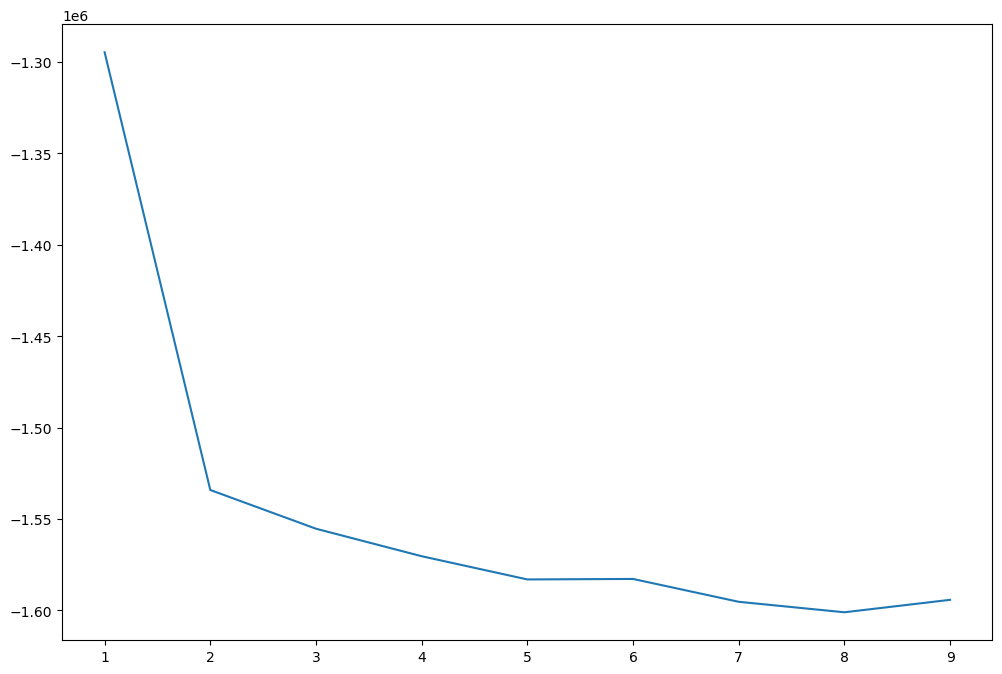

In [150]:
plt.plot([i for i in range(1, max_complexity)], ebics)
plt.show()

In [151]:
nor_axis = 0
if nor_axis is not None: Xfrols = normalize(newXr, axis=nor_axis)
else: Xfrols = newXr.copy()
frols_coeffs,selected_inds_list,_,_,_ = frols(wtr, Xfrols, max_nonzeros=max_complexity)
selected_inds_list = set(selected_inds_list)
selected_inds_list

{(0, 3, 14, 29, 34, 37, 39, 47, 55, 56),
 (0, 3, 29, 34, 37, 39, 47, 55, 56),
 (0, 3, 34, 37, 39, 47, 55, 56),
 (0, 34, 37, 39, 47, 55, 56),
 (0, 34, 37, 47, 55, 56),
 (0, 34, 37, 55, 56),
 (34, 37, 55, 56),
 (37, 55, 56),
 (55, 56),
 (56,)}

In [152]:
feature_hierarchy = abess_feature_hierarchy.union(selected_inds_list)

In [153]:
br1 = backward_refinement(feature_hierarchy, (newXr, wtr), mode='rfe', ic_type='bic', verbose=True)
br2 = backward_refinement(feature_hierarchy, (newXr, wtr), mode='k best', ic_type='bic', verbose=True)
br_u=br1+br2; br_u

RFE_PLinearRegression
(0, 3, 29, 34, 37, 39, 47, 55, 56)
(0, 3, 34, 37, 39, 47, 55, 56)
(0, 34, 37, 39, 47, 55, 56)
(0, 34, 37, 47, 55, 56)
(0, 34, 37, 55, 56)
(34, 37, 55, 56)
(37, 55, 56)
(55, 56)
(56,)
--------------------------------------------------
(0, 3, 14, 29, 34, 37, 39, 47, 55, 56)
(0, 3, 29, 34, 37, 39, 47, 55, 56)
--------------------------------------------------
(23, 33, 34, 37, 39, 41, 47, 55, 56)
(23, 33, 34, 39, 41, 47, 55, 56)
(23, 34, 39, 41, 47, 55, 56)
(23, 34, 39, 41, 55, 56)
(23, 34, 41, 55, 56)
(34, 41, 55, 56)
(41, 55, 56)
(55, 56)
--------------------------------------------------
(0, 19, 37, 39, 51, 55, 56)
(0, 19, 37, 39, 55, 56)
(0, 19, 37, 55, 56)
(0, 37, 55, 56)
(37, 55, 56)
--------------------------------------------------
(37, 55, 56)
--------------------------------------------------
(0, 34, 37, 47, 55, 56)
--------------------------------------------------
(23, 34, 37, 51, 55, 56)
(23, 34, 37, 55, 56)
(34, 37, 55, 56)
------------------------------

{1: ((56,), -235384.68155096806), 2: ((55, 56), -474814.5859281724), 3: ((37, 55, 56), -495998.8112468056), 4: ((34, 37, 55, 56), -511035.5519544687), 5: ((0, 34, 37, 55, 56), -523737.3352457459), 6: ((0, 34, 37, 47, 55, 56), -532603.7682714219), 7: ((0, 34, 37, 39, 47, 55, 56), -538334.8739961748), 8: ((0, 3, 34, 37, 39, 47, 55, 56), -542355.2319087497), 9: ((0, 3, 29, 34, 37, 39, 47, 55, 56), -546533.2082600782), 10: ((0, 3, 14, 29, 34, 37, 39, 47, 55, 56), -549286.6999980211)}

In [154]:
print("Ploting less than max_complexity")
for c in range(max_complexity+1, max(list(br_u.track.keys()))+1):
    del_c = br_u.delete(c)
    if del_c is not None: print(f"Delete {c} complexity")
    else: print(f"{c} not exist")

Ploting less than max_complexity


In [155]:
complexities = np.array(sorted(list(br_u.track.keys())))
bic_scores = []
eff_feature_names = []
for com in complexities:
    indices, bic = br_u.track[com]
    bic_scores.append(bic)
    print(indices, bic)
bic_scores = np.array(bic_scores)
min_bic_score = np.min(bic_scores)
div_scale = 1e3
rel_bic_scores = (bic_scores-min_bic_score)/div_scale

(56,) -235384.68155096806
(55, 56) -474814.5859281724
(37, 55, 56) -495998.8112468056
(34, 37, 55, 56) -511035.5519544687
(0, 34, 37, 55, 56) -523737.3352457459
(0, 34, 37, 47, 55, 56) -532603.7682714219
(0, 34, 37, 39, 47, 55, 56) -538334.8739961748
(0, 3, 34, 37, 39, 47, 55, 56) -542355.2319087497
(0, 3, 29, 34, 37, 39, 47, 55, 56) -546533.2082600782
(0, 3, 14, 29, 34, 37, 39, 47, 55, 56) -549286.6999980211


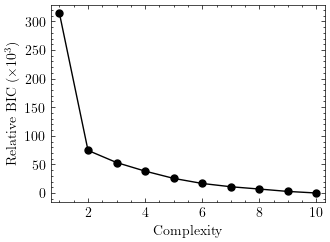

In [156]:
with plt.style.context('science'):
    fig, ax = plt.subplots()
    ax.plot(complexities, rel_bic_scores, color='black', linewidth=2.5//2)
    ax.scatter(complexities, rel_bic_scores, marker='o', c='black', s=25)
    plt.xlim(min(complexities)-0.3,max(complexities)+0.3)
    plt.ylabel(r"Relative BIC ($\times 10^{3}$)")
    plt.xlabel("Complexity")
    plt.tight_layout()
    plt.show()

In [157]:
# Uncombine
# array([ 307112.9782017 , -237159.67602557, -440173.04714535,
#        -475963.22679295, -500767.14218179, -515717.41664363,
#        -529173.01216944, -534591.53853473, -540469.31162411,
#        -546389.03193977])

# Combine
# array([-235384.68155097, -474814.58592817, -495998.81124681,
#        -511035.55195447, -523737.33524575, -532603.76827142,
#        -538334.87399617, -542355.23190875, -546533.20826008,
#        -549286.69999802])

# [1-10]

bic_scores

array([-235384.68155097, -474814.58592817, -495998.81124681,
       -511035.55195447, -523737.33524575, -532603.76827142,
       -538334.87399617, -542355.23190875, -546533.20826008,
       -549286.69999802])